# Rainfall–Terrain Driven Flood Exposure Assessment Using Multi-Year Hydro-Meteorological Data

## Data Visualization & Analysis

This notebook provides comprehensive visualizations for the geospatial analysis pipeline, including:
- **Part A**: Rainfall patterns and trends (CHIRPS data)
- **Part B**: DEM and hydrological analysis (coming soon)
- **Part C**: Flood exposure assessment (coming soon)

# Flood Exposure Geospatial Pipeline - Data Visualization

This notebook provides comprehensive visualizations for the geospatial analysis pipeline, including:
- Rainfall patterns and trends
- DEM and hydrological analysis
- Flood exposure assessment

## 1. Import Required Libraries

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from pathlib import Path

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

---

# Part A: Rainfall Analysis

## 2. Load the Rainfall Datacube

In [21]:
# Load the rainfall datacube (CHIRPS data clipped to AOI)
datacube_path = Path("../data/processed/chirps_clipped_aoi.nc")
datacube = xr.open_dataset(datacube_path)

# Display datacube information
print("Datacube Dimensions:", dict(datacube.dims))
print("\nDatacube Variables:", list(datacube.data_vars))
print("\nTime Range:", datacube.time.min().values, "to", datacube.time.max().values)
print("\nSpatial Extent:")
print(f"  Longitude: {float(datacube.longitude.min()):.4f} to {float(datacube.longitude.max()):.4f}")
print(f"  Latitude: {float(datacube.latitude.min()):.4f} to {float(datacube.latitude.max()):.4f}")

# Show the datacube structure
datacube

Datacube Dimensions: {'time': 84, 'latitude': 15, 'longitude': 16}

Datacube Variables: ['precip']

Time Range: 2018-01-01T00:00:00.000000000 to 2025-12-01T00:00:00.000000000

Spatial Extent:
  Longitude: 32.5250 to 33.2750
  Latitude: 15.6250 to 16.3250


C:\Users\Moham\AppData\Local\Temp\ipykernel_129200\4148510673.py:6: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print("Datacube Dimensions:", dict(datacube.dims))


<xarray.Dataset> Size: 81kB
Dimensions:    (time: 84, latitude: 15, longitude: 16)
Coordinates:
  * time       (time) datetime64[ns] 672B 2018-01-01 2018-02-01 ... 2025-12-01
  * latitude   (latitude) float32 60B 15.62 15.67 15.72 ... 16.22 16.27 16.32
  * longitude  (longitude) float32 64B 32.52 32.57 32.62 ... 33.18 33.22 33.27
Data variables:
    precip     (time, latitude, longitude) float32 81kB ...
Attributes: (12/15)
    Conventions:       CF-1.6
    title:             CHIRPS Version 2.0
    history:           created by Climate Hazards Center
    version:           Version 2.0
    data_created:      2023-12-18
    creator_name:      Pete Peterson
    ...                ...
    reference:         Funk, C.C., Peterson, P.J., Landsfeld, M.F., Pedreros,...
    comments:           time variable denotes the first day of the given month. 
    acknowledgements:  The Climate Hazards Center InfraRed Precipitation with...
    ftp_url:           ftp://chg-ftpout.geog.ucsb.edu/pub/chg/products/CHIRPS...
    website:           http://chg.geog.ucsb.edu/data/chirps/index.html
    faq:               http://chg-wiki.geog.ucsb.edu/wiki/CHIRPS_FAQ

## 3. Time Series - Average Rainfall Over AOI

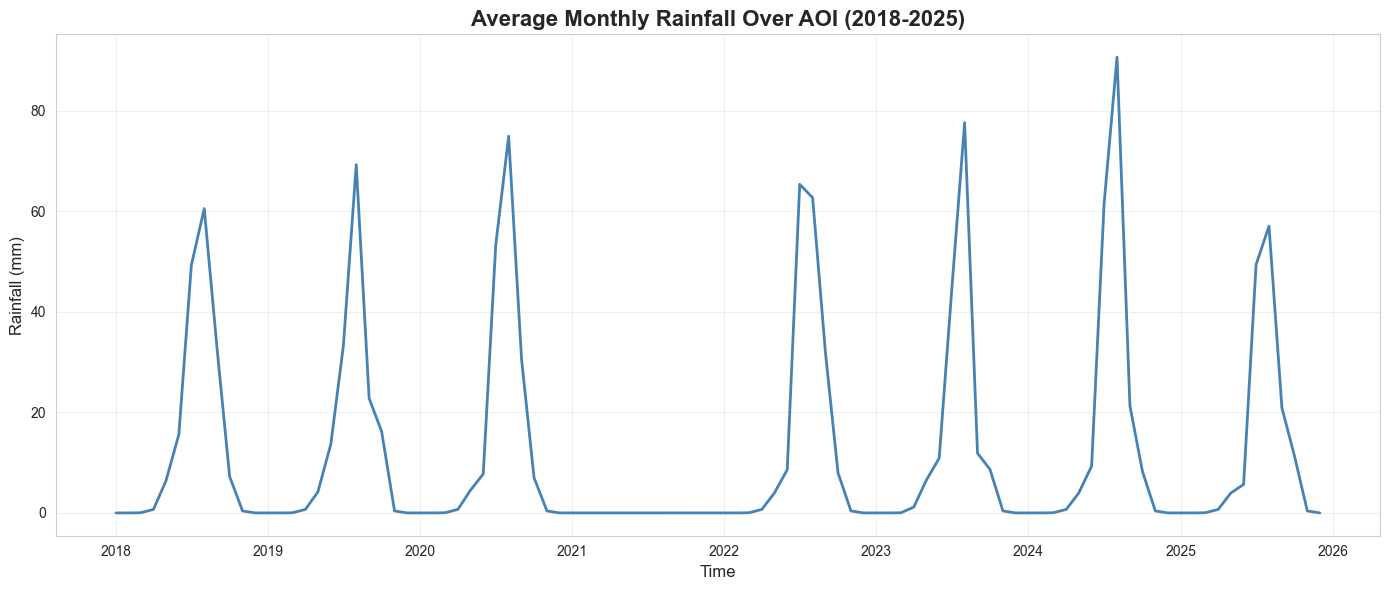


Rainfall Statistics:
  Mean: 14.30 mm
  Min: 0.00 mm
  Max: 90.65 mm
  Std Dev: 22.73 mm


In [22]:
# Calculate mean rainfall across all spatial pixels for each time step
mean_rainfall = datacube['precip'].mean(dim=['latitude', 'longitude'])

# Create time series plot
fig, ax = plt.subplots(figsize=(14, 6))
mean_rainfall.plot(ax=ax, linewidth=2, color='steelblue')
ax.set_title('Average Monthly Rainfall Over AOI (2018-2025)', fontsize=16, fontweight='bold')
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Rainfall (mm)', fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Show statistics
print(f"\nRainfall Statistics:")
print(f"  Mean: {float(mean_rainfall.mean()):.2f} mm")
print(f"  Min: {float(mean_rainfall.min()):.2f} mm")
print(f"  Max: {float(mean_rainfall.max()):.2f} mm")
print(f"  Std Dev: {float(mean_rainfall.std()):.2f} mm")

## 4. Yearly Comparison - Monthly Rainfall by Year

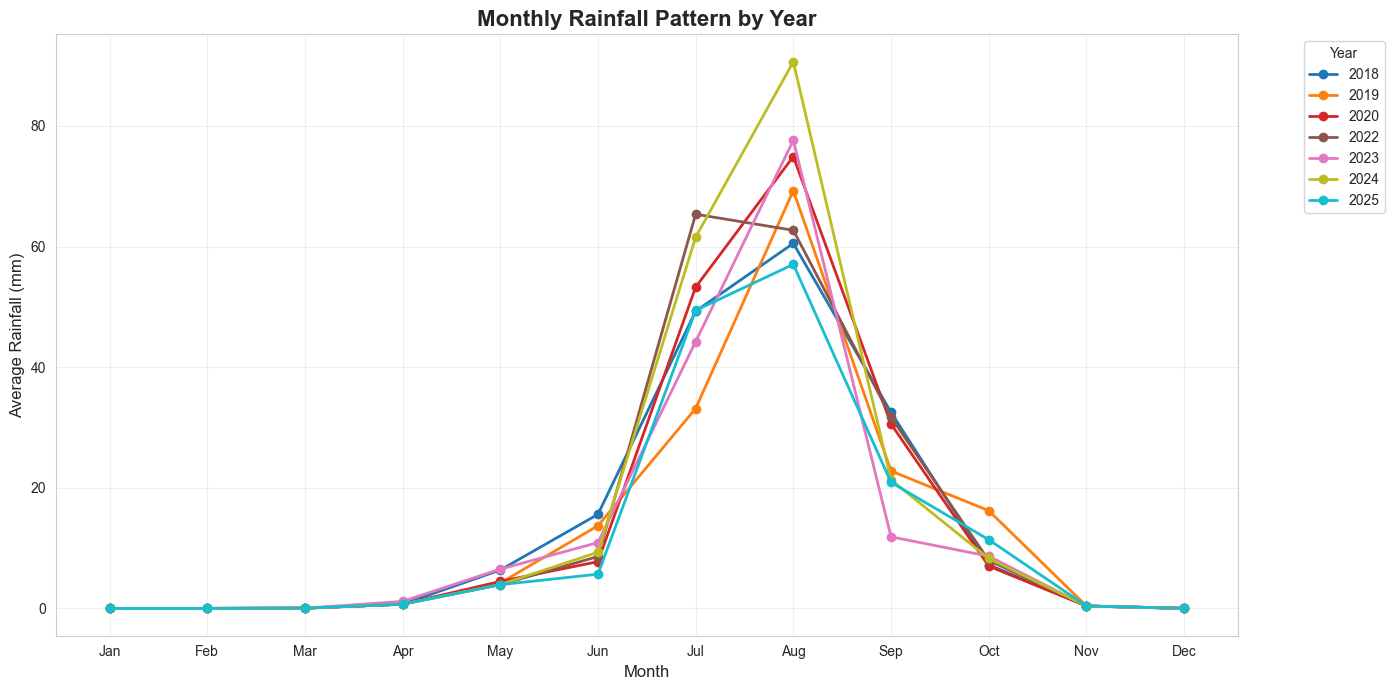

In [23]:
# Prepare data for yearly comparison
years = datacube['precip'].groupby('time.year').groups.keys()
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig, ax = plt.subplots(figsize=(14, 7))

# Plot each year
colors = plt.cm.tab10(np.linspace(0, 1, len(years)))
for i, year in enumerate(sorted(years)):
    year_data = datacube['precip'].sel(time=datacube['time.year'] == year)
    monthly_means = year_data.groupby('time.month').mean(dim='time').mean(dim=['latitude', 'longitude'])
    ax.plot(range(1, len(monthly_means) + 1), monthly_means.values, 
            marker='o', linewidth=2, label=str(year), color=colors[i])

ax.set_xticks(range(1, 13))
ax.set_xticklabels(months)
ax.set_title('Monthly Rainfall Pattern by Year', fontsize=16, fontweight='bold')
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Average Rainfall (mm)', fontsize=12)
ax.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Spatial Rainfall Pattern - 2025 (Last Year)

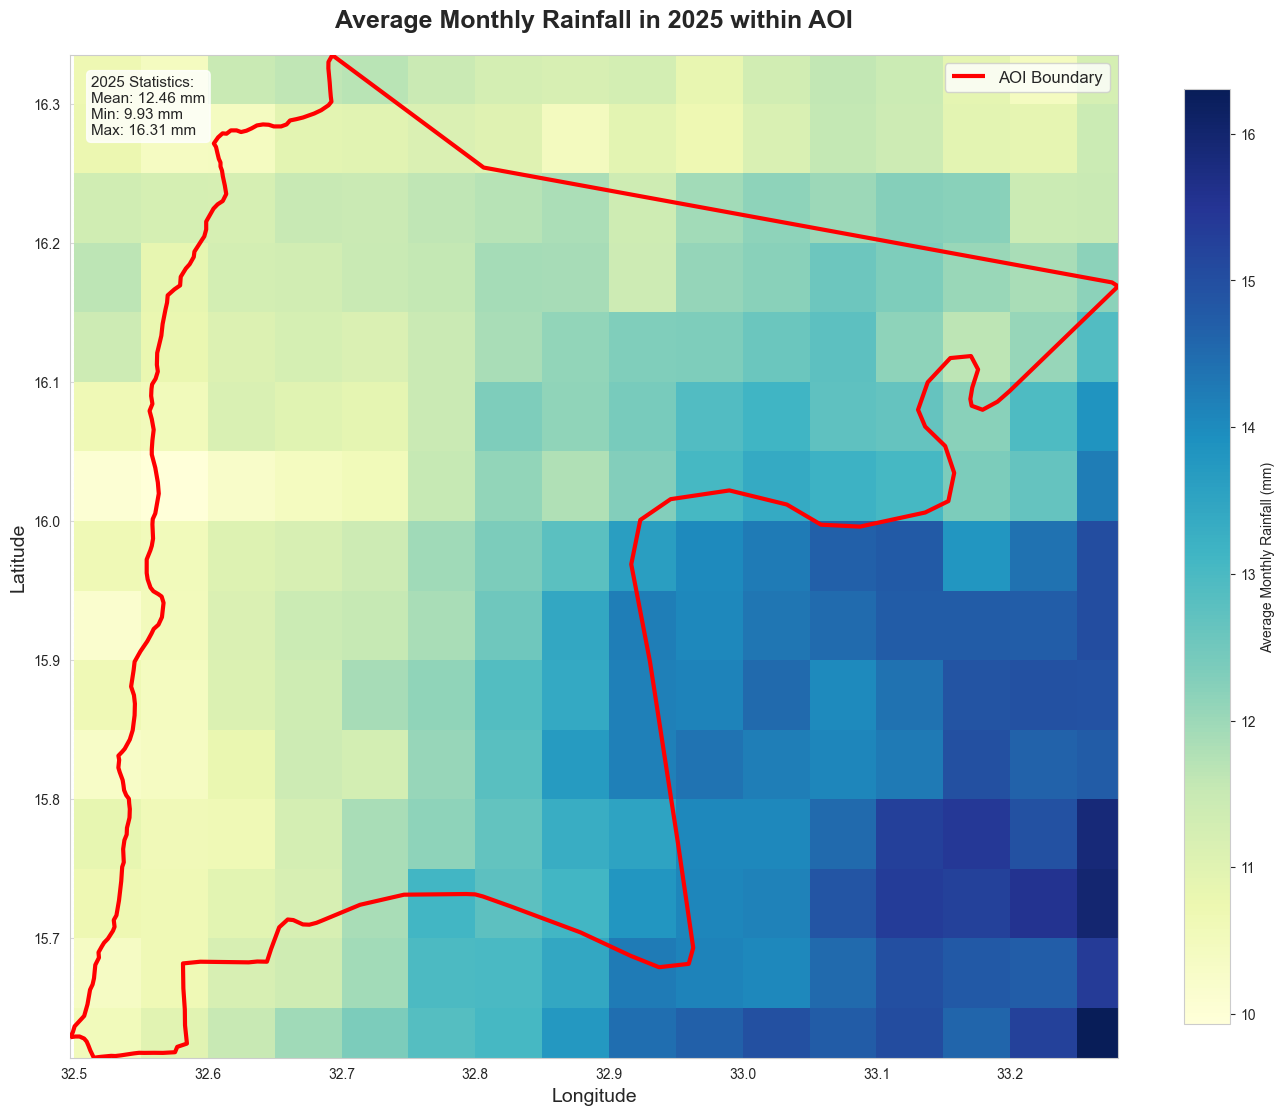


AOI Bounds: [32.4971676  15.6141559  33.28065901 16.3348999 ]
Data shape: (15, 16)


In [25]:
# Load AOI shapefile
aoi = gpd.read_file("../data/raw/vector/AOI.shp")

# Select 2025 data and calculate mean rainfall (datacube is already clipped to AOI bounding box)
rainfall_2025 = datacube['precip'].sel(time=datacube['time.year'] == 2025)
avg_rainfall_2025 = rainfall_2025.mean(dim='time')

# Create figure
fig, ax = plt.subplots(figsize=(14, 12))

# Plot the rainfall data
im = avg_rainfall_2025.plot(
    ax=ax,
    cmap='YlGnBu',
    cbar_kwargs={'label': 'Average Monthly Rainfall (mm)', 'shrink': 0.8}
)

# Overlay AOI boundary on top
aoi.boundary.plot(ax=ax, color='red', linewidth=3, label='AOI Boundary', zorder=10)

# Add title and labels
ax.set_title('Average Monthly Rainfall in 2025 within AOI', 
             fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
ax.legend(loc='upper right', fontsize=12)
ax.grid(True, alpha=0.3, linestyle='--', color='gray')

# Add statistics text box
stats_text = f"2025 Statistics:\nMean: {float(avg_rainfall_2025.mean()):.2f} mm\n"
stats_text += f"Min: {float(avg_rainfall_2025.min()):.2f} mm\n"
stats_text += f"Max: {float(avg_rainfall_2025.max()):.2f} mm"
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
        fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Set axis limits to AOI bounds
ax.set_xlim(aoi.total_bounds[0], aoi.total_bounds[2])
ax.set_ylim(aoi.total_bounds[1], aoi.total_bounds[3])

plt.tight_layout()
plt.show()

print(f"\nAOI Bounds: {aoi.total_bounds}")
print(f"Data shape: {avg_rainfall_2025.shape}")

---

# Part B: DEM & Hydrological Analysis

*Coming soon: Elevation models, flow accumulation, and drainage networks*

In [2]:

import rasterio
from rasterio.plot import show
import warnings
warnings.filterwarnings('ignore')

# Load DEM
dem_path = Path("../data/processed/dem_filled.tif")
with rasterio.open(dem_path) as src:
    dem_data = src.read(1)
    dem_profile = src.profile
    dem_bounds = src.bounds

# Load Slope
slope_path = Path("../data/processed/slope.tif")
with rasterio.open(slope_path) as src:
    slope_data = src.read(1)

# Load Flood Propensity Index
fpi_path = Path("../data/processed/flood_propensity_index.nc")
fpi_dataset = xr.open_dataset(fpi_path)
fpi = fpi_dataset['FPI'].values

print("✓ DEM loaded successfully")
print(f"  Shape: {dem_data.shape}")
print(f"  Elevation range: {np.nanmin(dem_data):.1f} to {np.nanmax(dem_data):.1f} m")
print(f"  Bounds: {dem_bounds}")

print("\n✓ Slope loaded successfully")
print(f"  Shape: {slope_data.shape}")
print(f"  Slope range: {np.nanmin(slope_data):.2f}° to {np.nanmax(slope_data):.2f}°")

print("\n✓ Flood Propensity Index loaded successfully")
print(f"  Shape: {fpi.shape}")
print(f"  FPI range: {np.nanmin(fpi):.4f} to {np.nanmax(fpi):.4f}")


✓ DEM loaded successfully
  Shape: (2596, 2821)
  Elevation range: 0.0 to 255.0 m
  Bounds: BoundingBox(left=32.497083333333336, bottom=15.614027777777777, right=33.28069444444445, top=16.33513888888889)

✓ Slope loaded successfully
  Shape: (2596, 2821)
  Slope range: 0.00° to 80.55°

✓ Flood Propensity Index loaded successfully
  Shape: (50, 50)
  FPI range: 0.1217 to 0.8234


## 7. Visualize Digital Elevation Model (DEM)

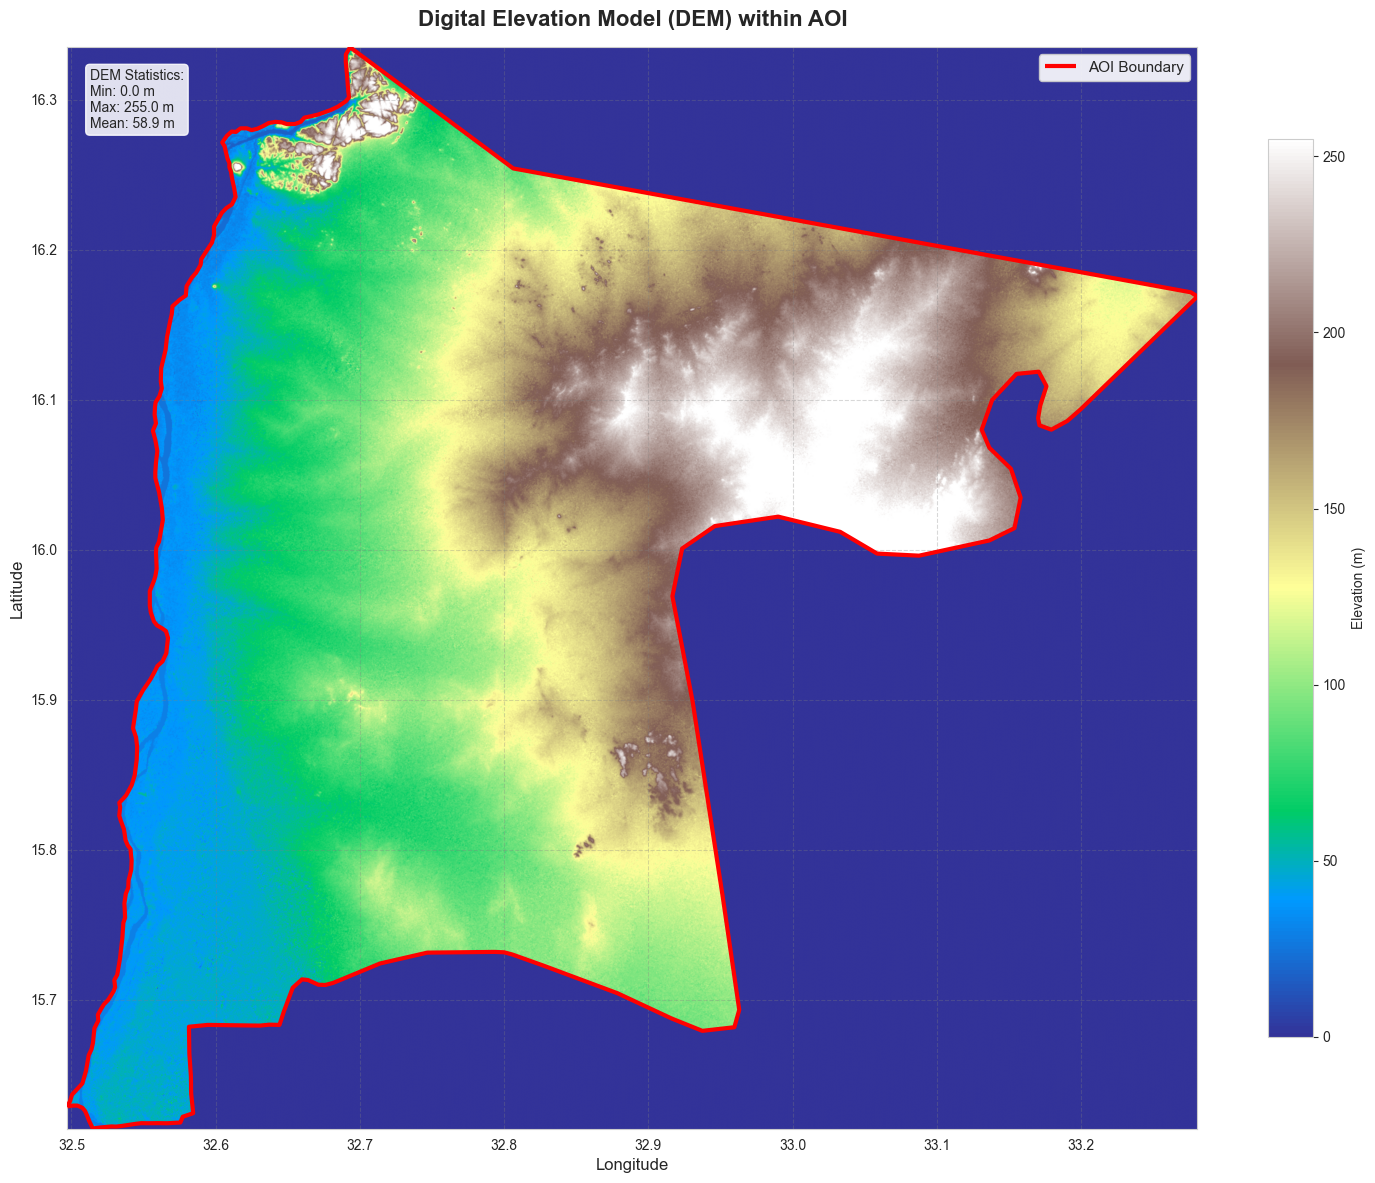

✓ DEM visualization complete


In [3]:

# Reload AOI if needed
aoi = gpd.read_file("../data/raw/vector/AOI.shp")

# Create DEM visualization
fig, ax = plt.subplots(figsize=(15, 12))

# Plot DEM
im_dem = ax.imshow(dem_data, cmap='terrain', extent=[dem_bounds.left, dem_bounds.right, 
                                                       dem_bounds.bottom, dem_bounds.top], 
                   origin='upper', aspect='auto')

# Overlay AOI boundary with red lines
aoi.boundary.plot(ax=ax, color='red', linewidth=3, label='AOI Boundary', zorder=10)

# Add colorbar
cbar = plt.colorbar(im_dem, ax=ax, label='Elevation (m)', shrink=0.8)

# Title and labels
ax.set_title('Digital Elevation Model (DEM) within AOI', fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.legend(loc='upper right', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--', color='gray')

# Add statistics
stats_dem = f"DEM Statistics:\nMin: {np.nanmin(dem_data):.1f} m\nMax: {np.nanmax(dem_data):.1f} m\nMean: {np.nanmean(dem_data):.1f} m"
ax.text(0.02, 0.98, stats_dem, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.85))

plt.tight_layout()
plt.show()

print("✓ DEM visualization complete")


## 8. Calculate and Visualize Flow Accumulation

Computing flow direction (D8 algorithm)...
Computing flow accumulation...
✓ Flow accumulation calculated successfully
  Flow accumulation range: 1 to 341 cells


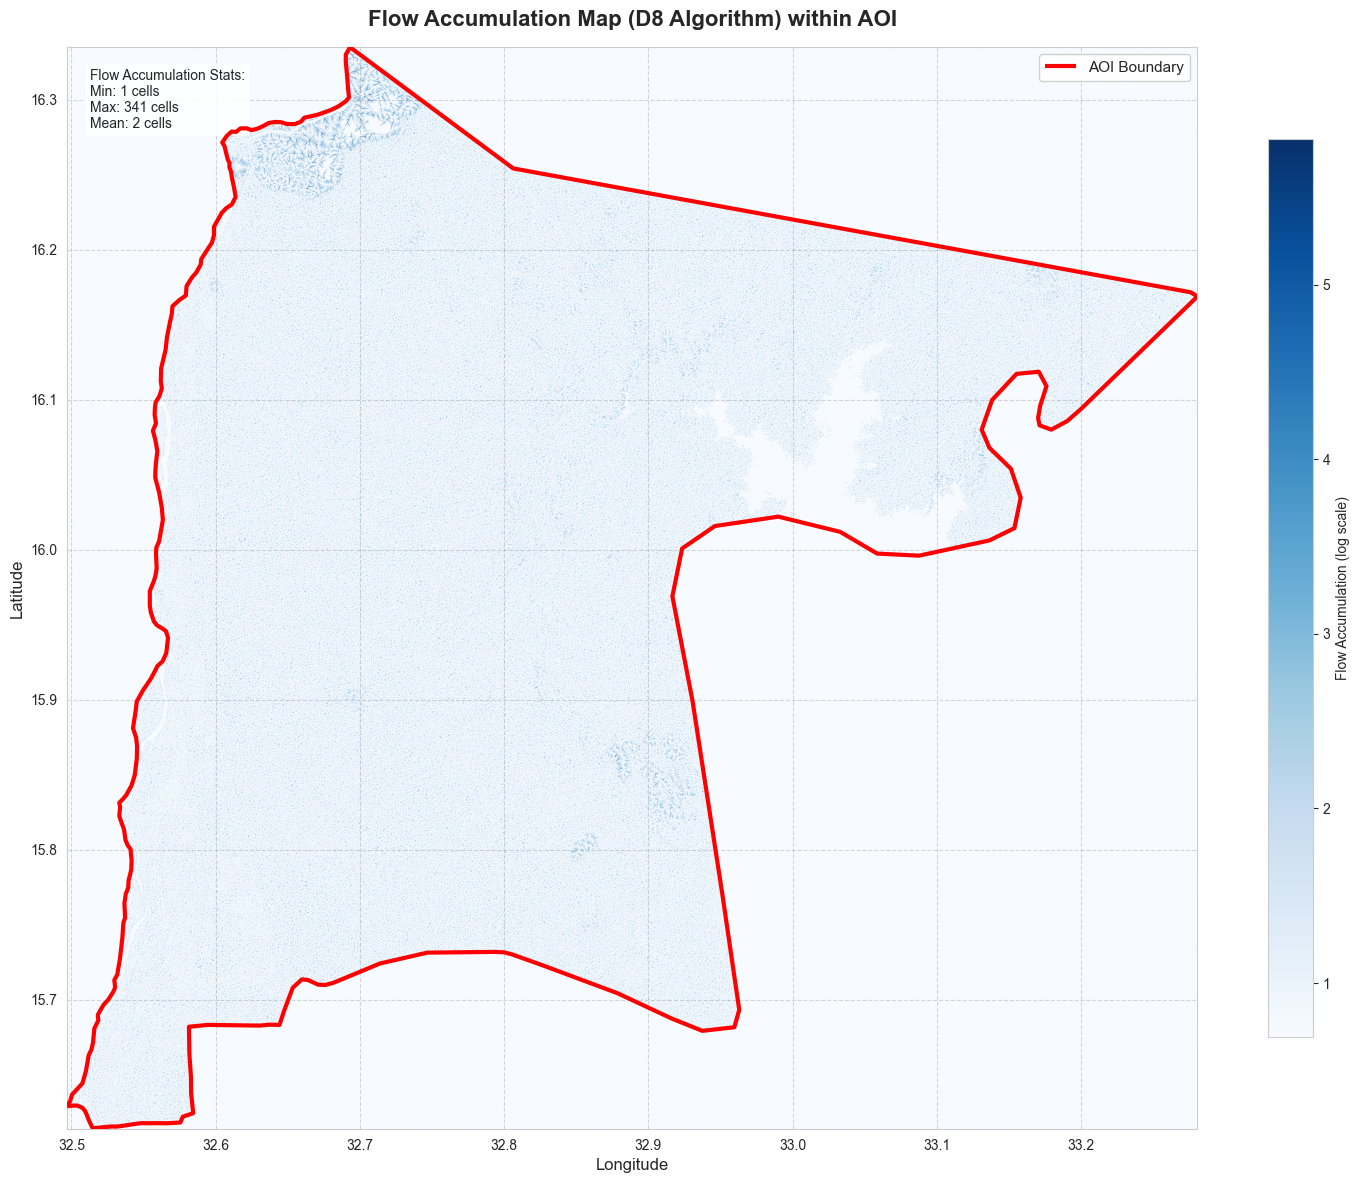

✓ Flow accumulation visualization complete


In [4]:

# Import hydrology functions
import sys
sys.path.insert(0, '../src')
from _03_analysis.hydrology import calculate_flow_direction, calculate_flow_accumulation

# Calculate flow direction and accumulation
print("Computing flow direction (D8 algorithm)...")
flow_dir = calculate_flow_direction(dem_data)

print("Computing flow accumulation...")
flow_acc = calculate_flow_accumulation(flow_dir).astype(np.float64)

# Apply log scale for better visualization
flow_acc_log = np.log1p(flow_acc)

print("✓ Flow accumulation calculated successfully")
print(f"  Flow accumulation range: {np.nanmin(flow_acc):.0f} to {np.nanmax(flow_acc):.0f} cells")

# Visualize flow accumulation
fig, ax = plt.subplots(figsize=(15, 12))

# Plot flow accumulation with log scale
im_flow = ax.imshow(flow_acc_log, cmap='Blues', extent=[dem_bounds.left, dem_bounds.right,
                                                          dem_bounds.bottom, dem_bounds.top],
                   origin='upper', aspect='auto')

# Overlay AOI boundary with red lines
aoi.boundary.plot(ax=ax, color='red', linewidth=3, label='AOI Boundary', zorder=10)

# Add colorbar
cbar_flow = plt.colorbar(im_flow, ax=ax, label='Flow Accumulation (log scale)', shrink=0.8)

# Title and labels
ax.set_title('Flow Accumulation Map (D8 Algorithm) within AOI', fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.legend(loc='upper right', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--', color='gray')

# Add statistics
stats_flow = f"Flow Accumulation Stats:\nMin: {np.nanmin(flow_acc):.0f} cells\nMax: {np.nanmax(flow_acc):.0f} cells\nMean: {np.nanmean(flow_acc):.0f} cells"
ax.text(0.02, 0.98, stats_flow, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.85))

plt.tight_layout()
plt.show()

print("✓ Flow accumulation visualization complete")


## 9. Visualize Topographic Wetness Index (TWI)

flow_acc shape: (2596, 2821), slope_data shape: (2596, 2821), dem_data shape: (2596, 2821)
✓ Topographic Wetness Index (TWI) computed
  TWI range: -1.79 to 12.52
  TWI mean: 5.40


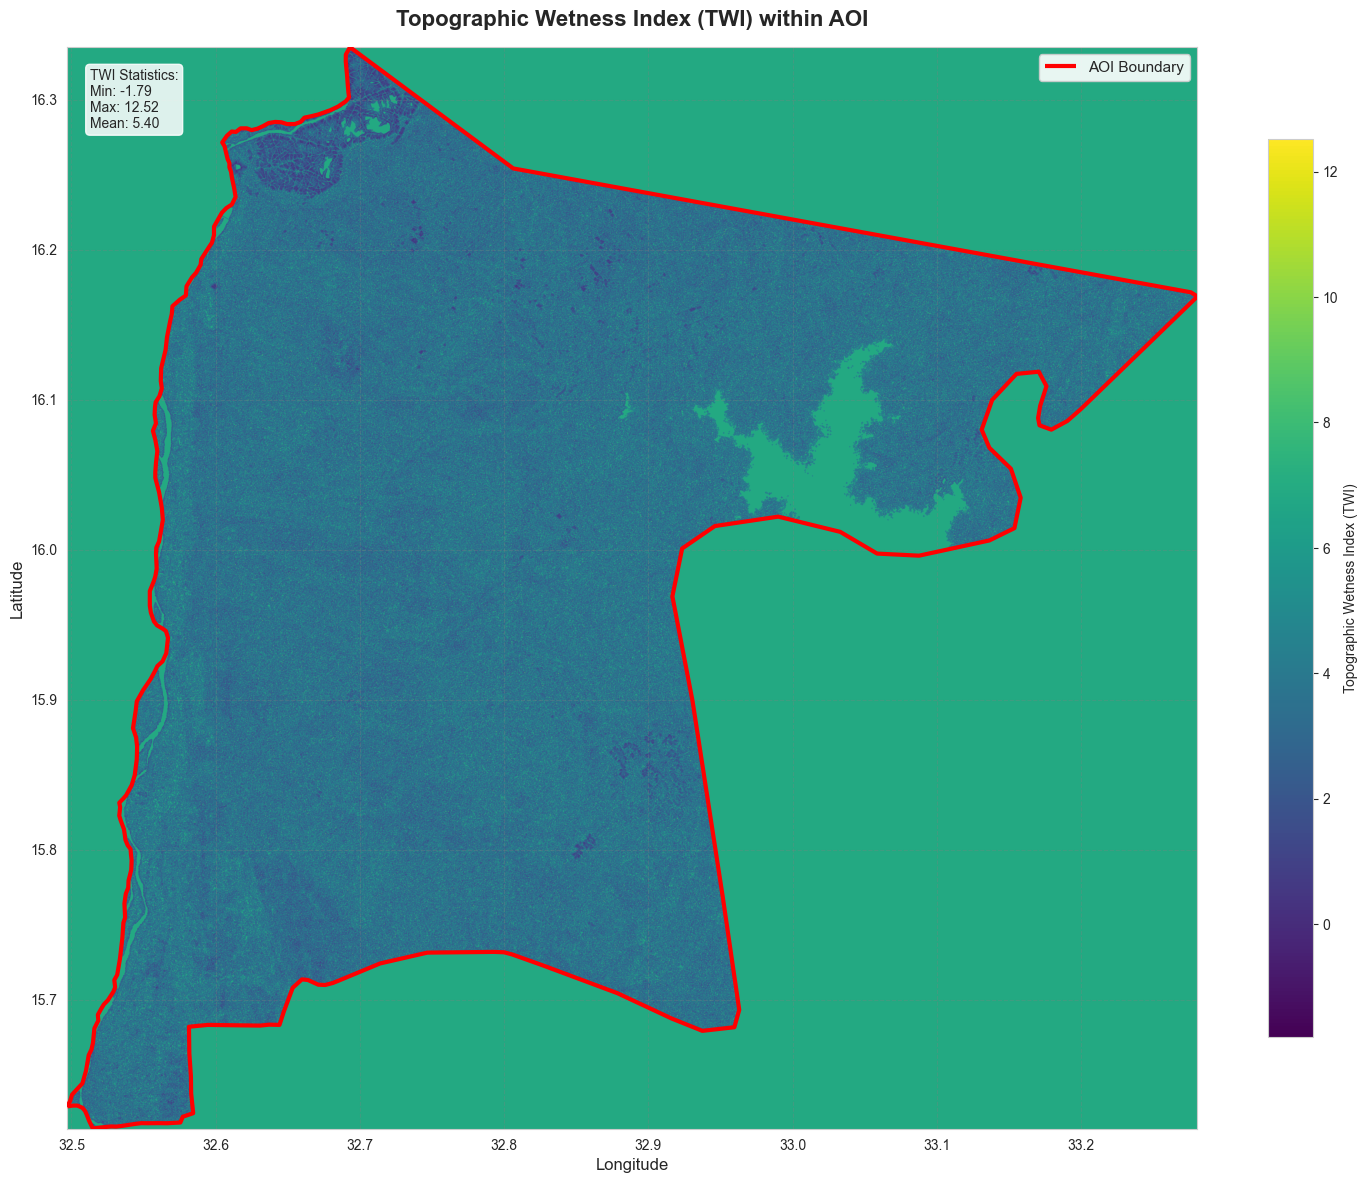

✓ Topographic Wetness Index (TWI) visualization complete


In [14]:
# Define extents for FPI maps (from xarray dataset)
lon_extent = [float(fpi_dataset.longitude.min()), float(fpi_dataset.longitude.max())]
lat_extent = [float(fpi_dataset.latitude.min()), float(fpi_dataset.latitude.max())]

# Use dem-based flow_acc (already computed, matches dem_data and slope_data dimensions)
# Note: flow_acc shape (2596, 2821) matches dem_data and slope_data
print(f"flow_acc shape: {flow_acc.shape}, slope_data shape: {slope_data.shape}, dem_data shape: {dem_data.shape}")

# Assume cell size = 1 (or adjust based on your actual data resolution)
cell_size = 1.0  # in meters or map units

# Compute specific catchment area
sca = flow_acc * cell_size

# Convert slope from degrees to radians for TWI calculation
slope_rad = np.radians(slope_data)

# Avoid division by zero and log of zero
# Set minimum slope to avoid infinite values
slope_rad = np.where(slope_rad == 0, 0.001, slope_rad)

# Compute TWI: ln(SCA / tan(slope))
# Add small value to avoid log(0)
twi = np.log((sca + 1e-6) / (np.tan(slope_rad) + 1e-6))

# Replace invalid values
twi = np.where(np.isfinite(twi), twi, np.nan)

print("✓ Topographic Wetness Index (TWI) computed")
print(f"  TWI range: {np.nanmin(twi):.2f} to {np.nanmax(twi):.2f}")
print(f"  TWI mean: {np.nanmean(twi):.2f}")

# Visualize TWI
fig, ax = plt.subplots(figsize=(15, 12))

# Plot TWI with proper extent alignment using dem_bounds
im_twi = ax.imshow(twi, cmap='viridis', extent=[dem_bounds.left, dem_bounds.right,
                                                   dem_bounds.bottom, dem_bounds.top],
                   origin='upper', aspect='auto')

# Overlay AOI boundary with red lines
aoi.boundary.plot(ax=ax, color='red', linewidth=3, label='AOI Boundary', zorder=10)

# Add colorbar
cbar_twi = plt.colorbar(im_twi, ax=ax, label='Topographic Wetness Index (TWI)', shrink=0.8)

# Title and labels
ax.set_title('Topographic Wetness Index (TWI) within AOI', fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.legend(loc='upper right', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--', color='gray')

# Add statistics
stats_twi = f"TWI Statistics:\nMin: {np.nanmin(twi):.2f}\nMax: {np.nanmax(twi):.2f}\nMean: {np.nanmean(twi):.2f}"
ax.text(0.02, 0.98, stats_twi, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.85))

plt.tight_layout()
plt.show()

print("✓ Topographic Wetness Index (TWI) visualization complete")

## 10. Visualize Flood Propensity Index (FPI)

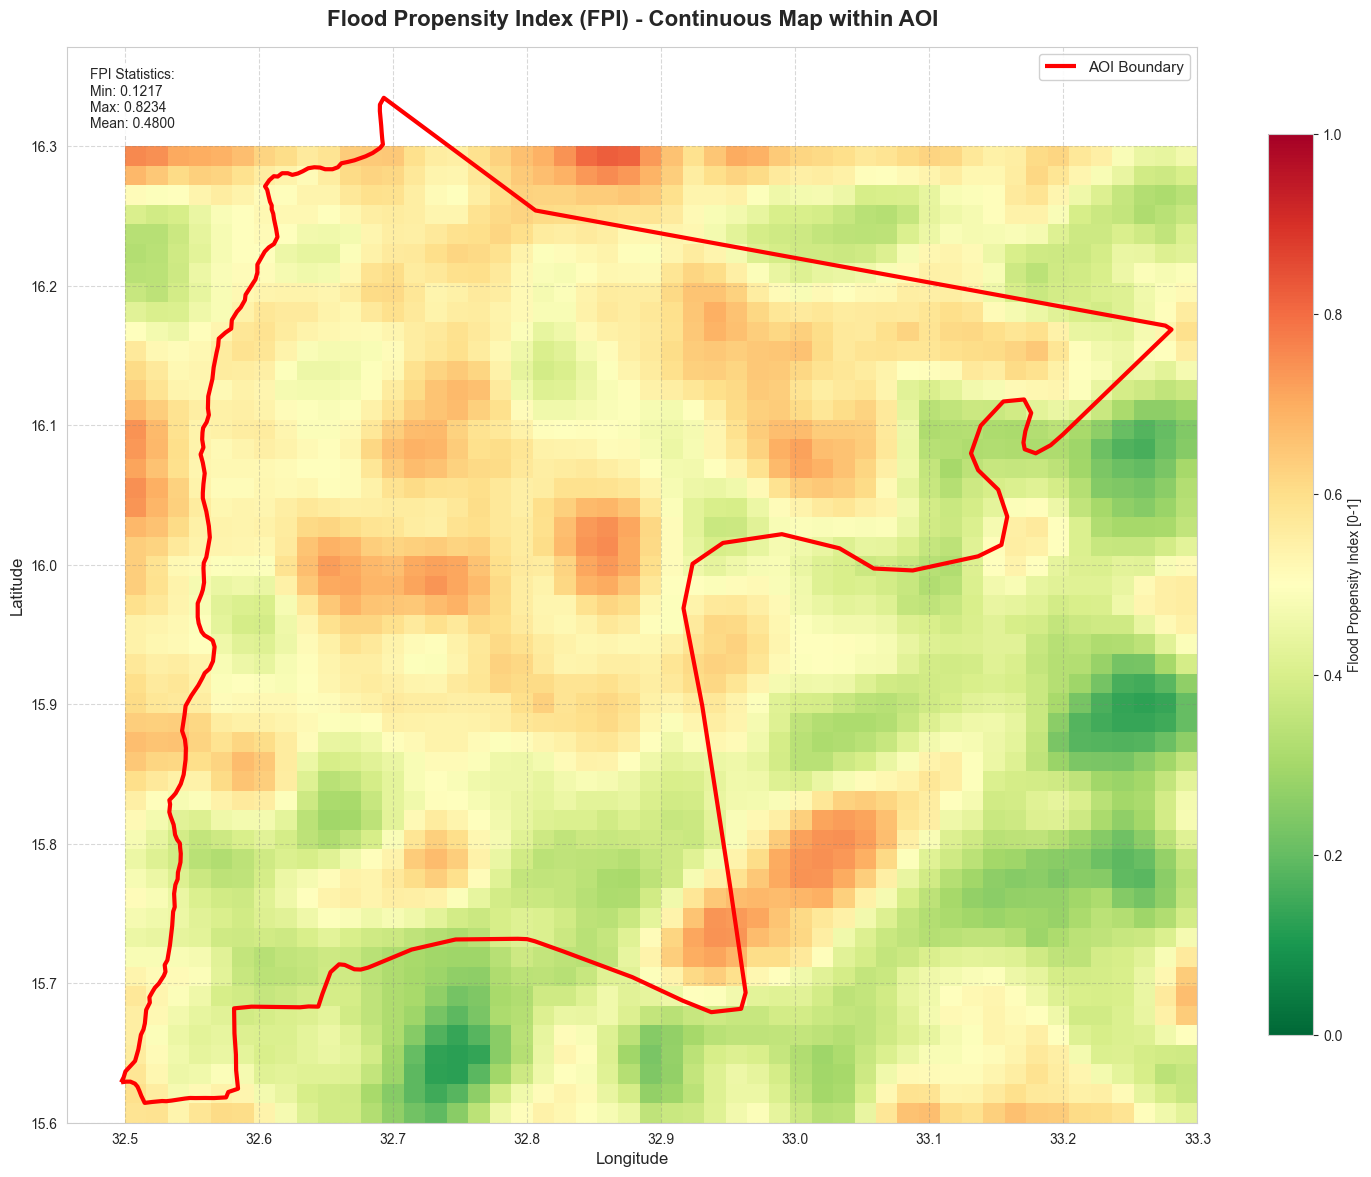

✓ Flood Propensity Index (continuous) visualization complete


In [ ]:

# Get extent for FPI from xarray dataset (already computed in TWI cell)
# Create figure for FPI continuous
fig, ax = plt.subplots(figsize=(15, 12))

# Plot FPI continuous values
im_fpi = ax.imshow(fpi, cmap='RdYlGn_r', extent=[lon_extent[0], lon_extent[1],
                                                   lat_extent[0], lat_extent[1]],
                  origin='upper', aspect='auto', vmin=0, vmax=1)

# Overlay AOI boundary with red lines
aoi.boundary.plot(ax=ax, color='red', linewidth=3, label='AOI Boundary', zorder=10)

# Add colorbar
cbar_fpi = plt.colorbar(im_fpi, ax=ax, label='Flood Propensity Index [0-1]', shrink=0.8)

# Title and labels
ax.set_title('Flood Propensity Index (FPI) - Continuous Map within AOI', fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.legend(loc='upper right', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--', color='gray')

# Add statistics
stats_fpi = f"FPI Statistics:\nMin: {np.nanmin(fpi):.4f}\nMax: {np.nanmax(fpi):.4f}\nMean: {np.nanmean(fpi):.4f}"
ax.text(0.02, 0.98, stats_fpi, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.85))

plt.tight_layout()
plt.show()

print("✓ Flood Propensity Index (continuous) visualization complete")


## 12. Comparative Analysis - DEM, Flow Accumulation, TWI, and FPI

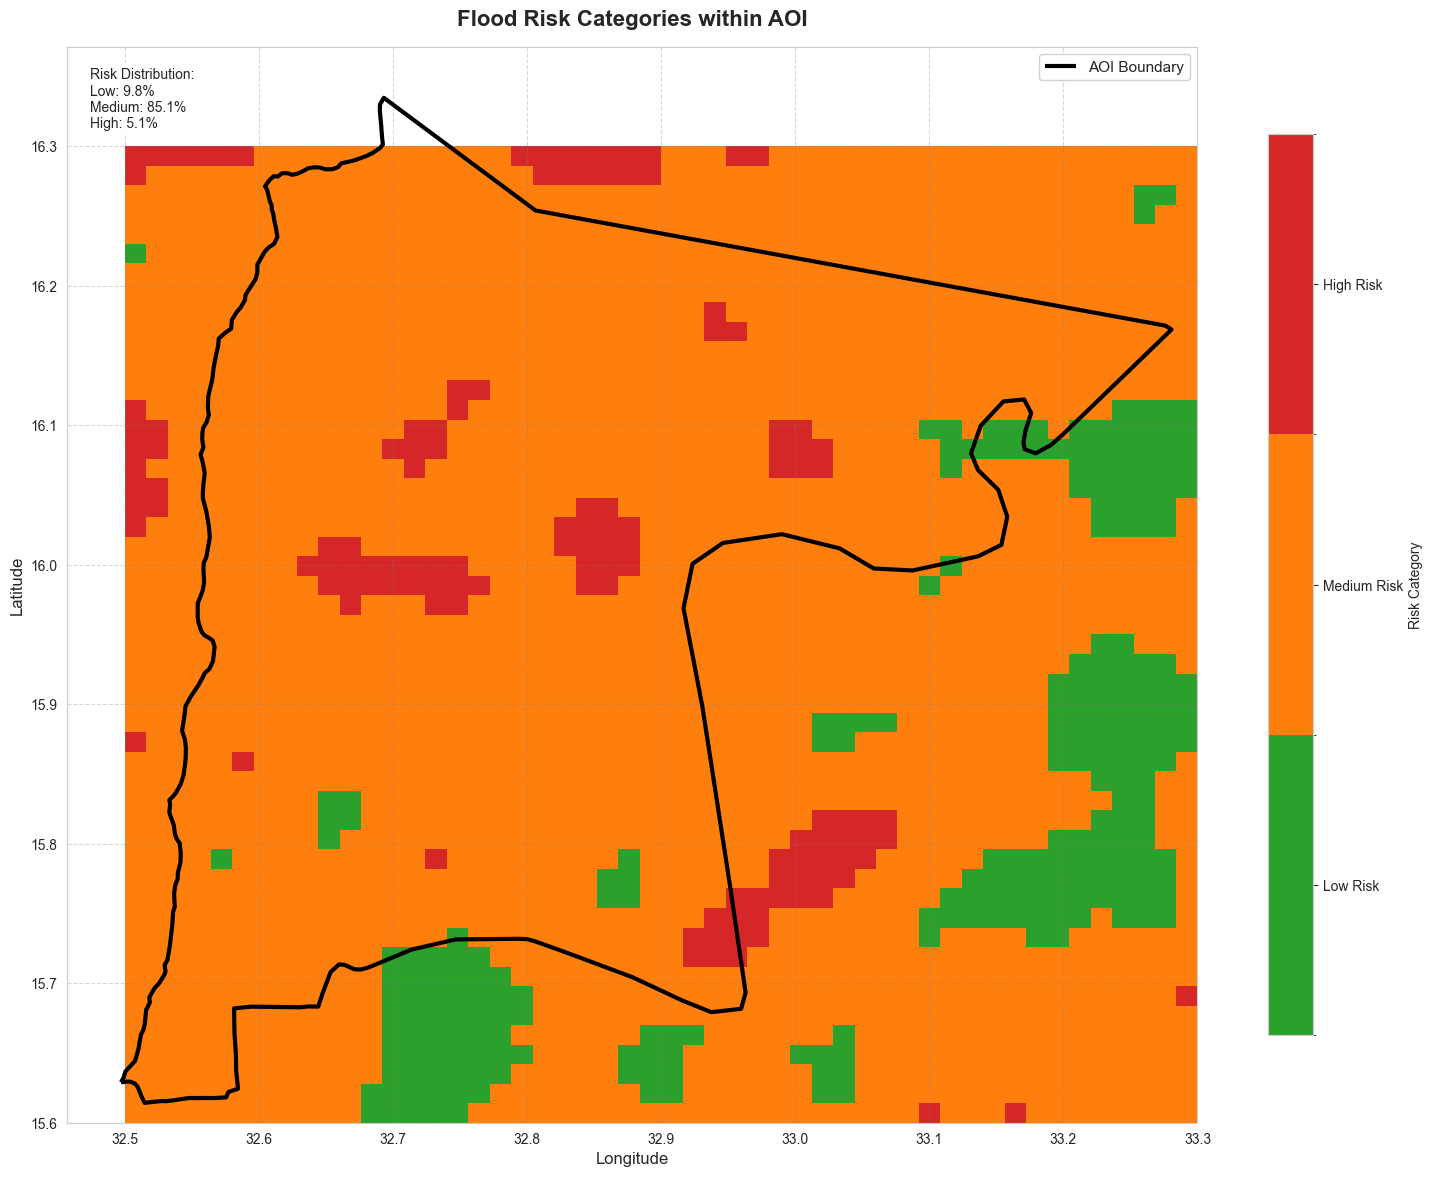

✓ Flood Risk Categories visualization complete
  Low Risk (<0.33): 244 pixels (9.8%)
  Medium Risk (0.33-0.66): 2,128 pixels (85.1%)
  High Risk (≥0.66): 128 pixels (5.1%)


In [6]:

# Create categorical FPI (Low, Medium, High)
fpi_categorical = np.zeros_like(fpi, dtype=int)
fpi_categorical[fpi >= 0.66] = 3  # High risk
fpi_categorical[(fpi >= 0.33) & (fpi < 0.66)] = 2  # Medium risk
fpi_categorical[fpi < 0.33] = 1  # Low risk

# Create figure for categorical FPI
fig, ax = plt.subplots(figsize=(15, 12))

# Create custom colormap for risk categories
from matplotlib.colors import ListedColormap, BoundaryNorm
colors_risk = ['#2ca02c', '#ff7f0e', '#d62728']  # Green (Low), Orange (Medium), Red (High)
cmap_risk = ListedColormap(colors_risk)
norm_risk = BoundaryNorm([0.5, 1.5, 2.5, 3.5], cmap_risk.N)

# Plot categorical FPI
im_fpi_cat = ax.imshow(fpi_categorical, cmap=cmap_risk, norm=norm_risk,
                       extent=[lon_extent[0], lon_extent[1], lat_extent[0], lat_extent[1]],
                       origin='upper', aspect='auto')

# Overlay AOI boundary with red lines
aoi.boundary.plot(ax=ax, color='black', linewidth=3, label='AOI Boundary', zorder=10)

# Add colorbar with custom labels
cbar_cat = plt.colorbar(im_fpi_cat, ax=ax, ticks=[1, 2, 3], label='Risk Category', shrink=0.8)
cbar_cat.ax.set_yticklabels(['Low Risk', 'Medium Risk', 'High Risk'])

# Title and labels
ax.set_title('Flood Risk Categories within AOI', fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.legend(loc='upper right', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--', color='gray')

# Add statistics
low_pct = 100 * np.sum(fpi_categorical == 1) / fpi_categorical.size
med_pct = 100 * np.sum(fpi_categorical == 2) / fpi_categorical.size
high_pct = 100 * np.sum(fpi_categorical == 3) / fpi_categorical.size

stats_risk = f"Risk Distribution:\nLow: {low_pct:.1f}%\nMedium: {med_pct:.1f}%\nHigh: {high_pct:.1f}%"
ax.text(0.02, 0.98, stats_risk, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.85))

plt.tight_layout()
plt.show()

print("✓ Flood Risk Categories visualization complete")
print(f"  Low Risk (<0.33): {np.sum(fpi_categorical == 1):,} pixels ({low_pct:.1f}%)")
print(f"  Medium Risk (0.33-0.66): {np.sum(fpi_categorical == 2):,} pixels ({med_pct:.1f}%)")
print(f"  High Risk (≥0.66): {np.sum(fpi_categorical == 3):,} pixels ({high_pct:.1f}%)")


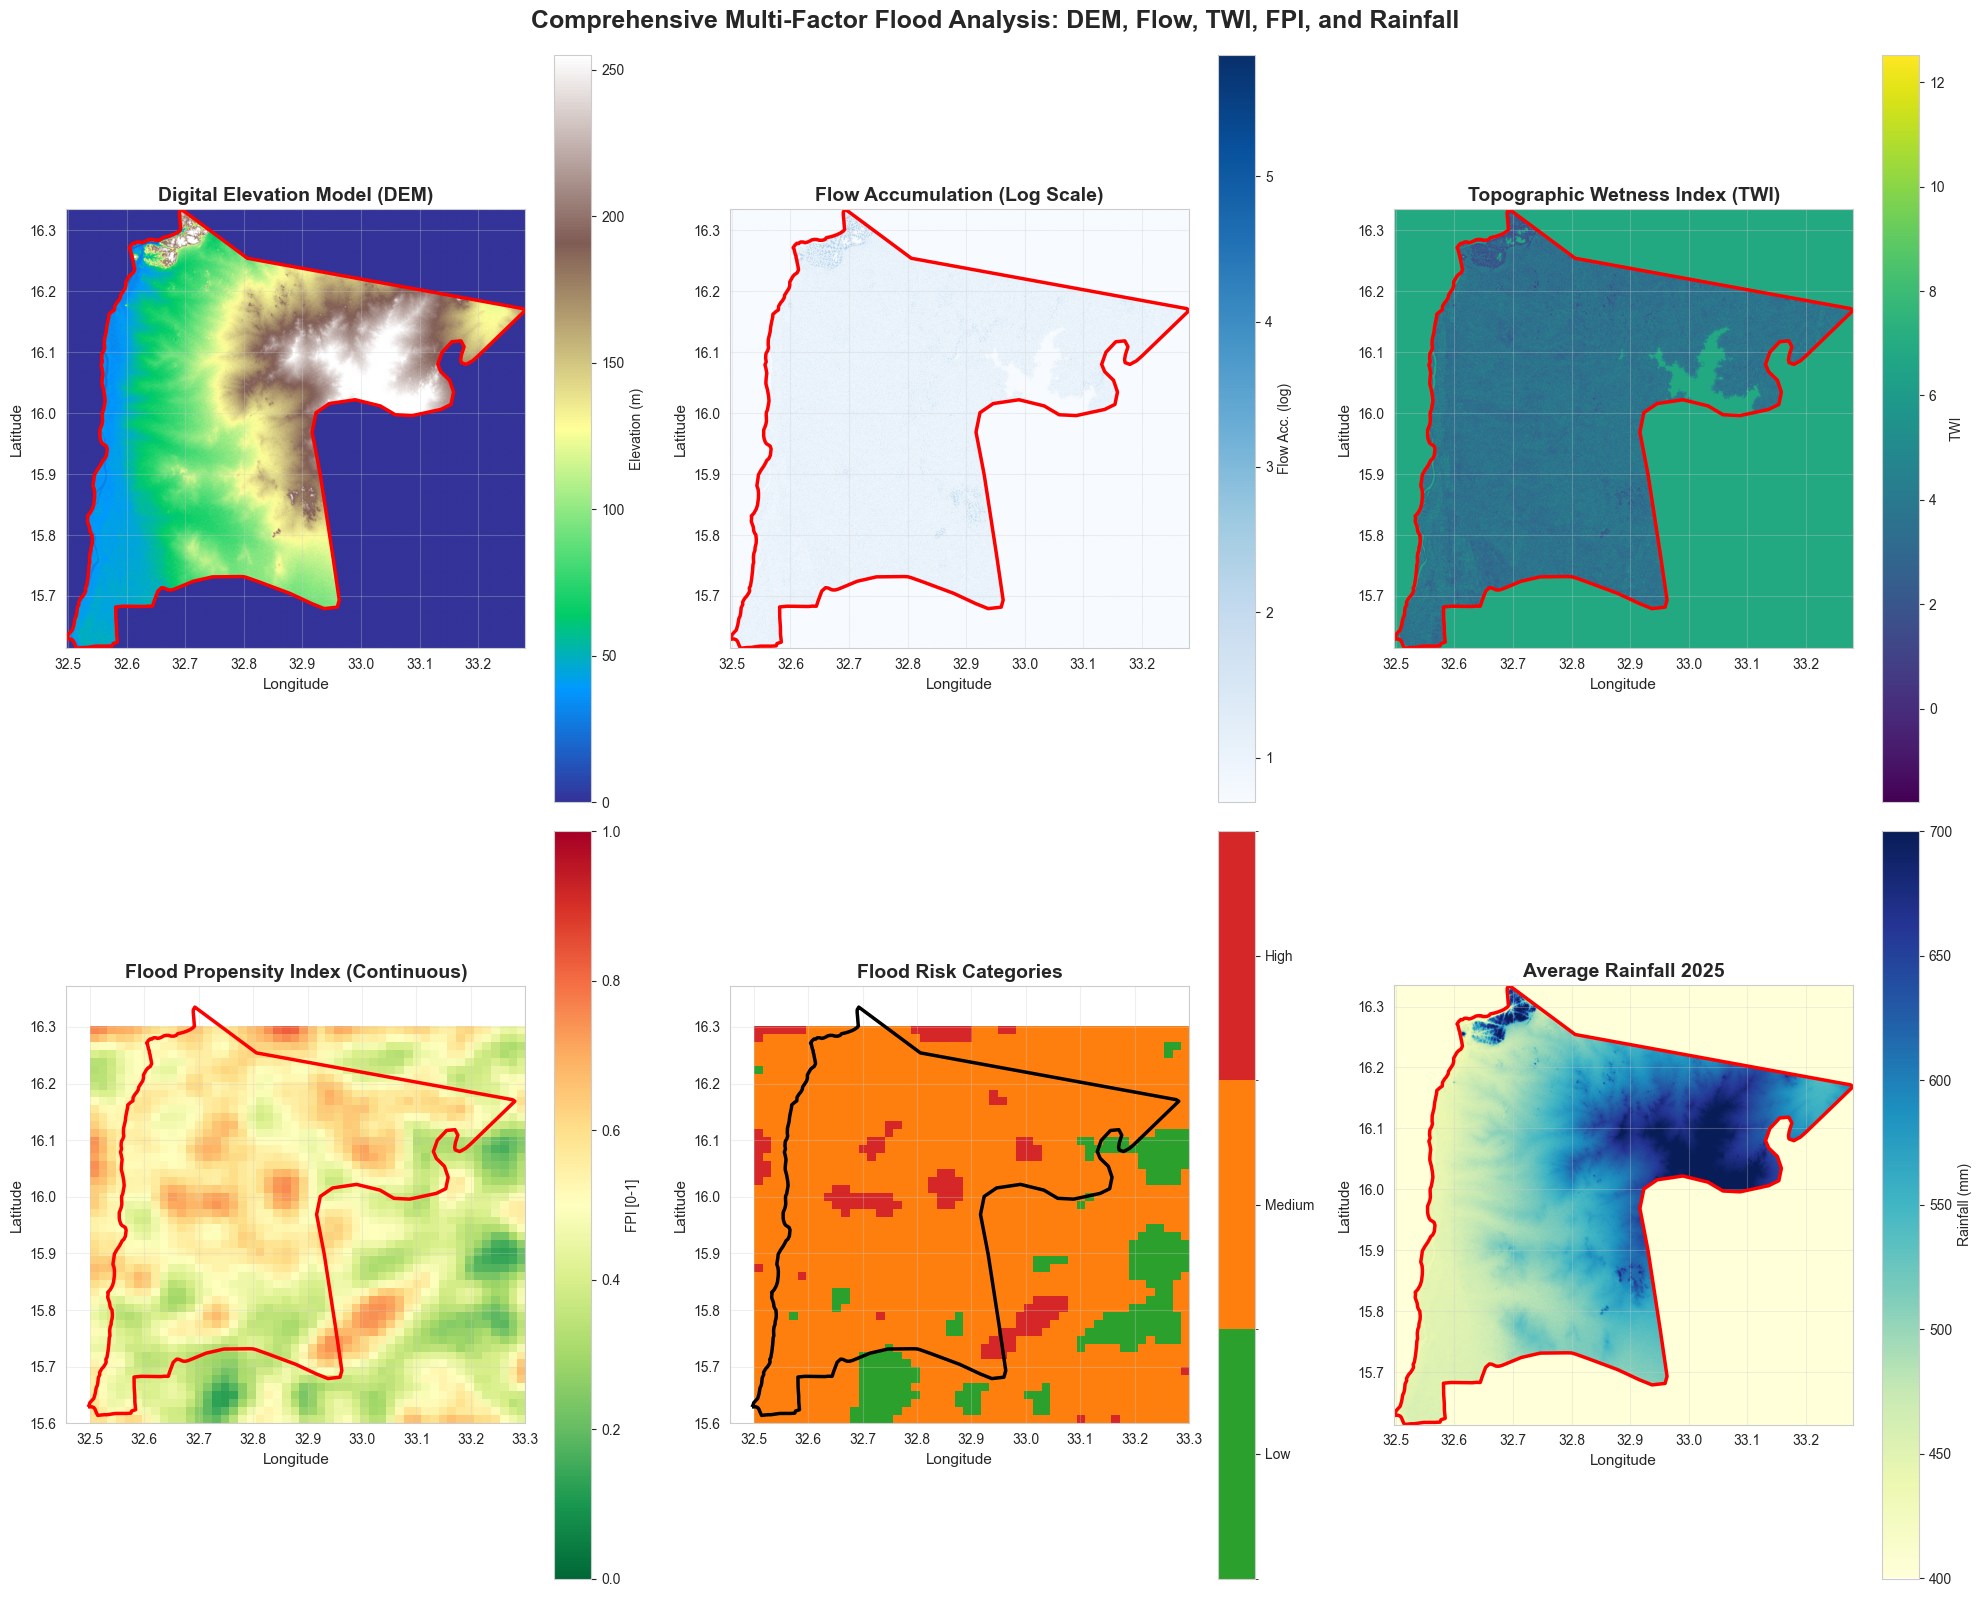

✓ Comprehensive analysis visualization complete


In [20]:
# Create a 6-panel comparison figure
plt.figure(figsize=(20, 16))

# Panel 1: DEM
ax1 = plt.subplot(2, 3, 1)
im1 = ax1.imshow(dem_data, cmap='terrain', extent=[dem_bounds.left, dem_bounds.right,
                                                     dem_bounds.bottom, dem_bounds.top],
                 origin='upper', aspect='auto')
aoi.boundary.plot(ax=ax1, color='red', linewidth=2.5)
ax1.set_title('Digital Elevation Model (DEM)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Longitude', fontsize=11)
ax1.set_ylabel('Latitude', fontsize=11)
plt.colorbar(im1, ax=ax1, label='Elevation (m)')
ax1.grid(True, alpha=0.3)

# Panel 2: Flow Accumulation
ax2 = plt.subplot(2, 3, 2)
im2 = ax2.imshow(flow_acc_log, cmap='Blues', extent=[dem_bounds.left, dem_bounds.right,
                                                       dem_bounds.bottom, dem_bounds.top],
                 origin='upper', aspect='auto')
aoi.boundary.plot(ax=ax2, color='red', linewidth=2.5)
ax2.set_title('Flow Accumulation (Log Scale)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Longitude', fontsize=11)
ax2.set_ylabel('Latitude', fontsize=11)
plt.colorbar(im2, ax=ax2, label='Flow Acc. (log)')
ax2.grid(True, alpha=0.3)

# Panel 3: Topographic Wetness Index
ax3 = plt.subplot(2, 3, 3)
im3 = ax3.imshow(twi, cmap='viridis', extent=[dem_bounds.left, dem_bounds.right,
                                                dem_bounds.bottom, dem_bounds.top],
                 origin='upper', aspect='auto')
aoi.boundary.plot(ax=ax3, color='red', linewidth=2.5)
ax3.set_title('Topographic Wetness Index (TWI)', fontsize=14, fontweight='bold')
ax3.set_xlabel('Longitude', fontsize=11)
ax3.set_ylabel('Latitude', fontsize=11)
plt.colorbar(im3, ax=ax3, label='TWI')
ax3.grid(True, alpha=0.3)

# Panel 4: FPI Continuous
ax4 = plt.subplot(2, 3, 4)
im4 = ax4.imshow(fpi, cmap='RdYlGn_r', extent=[lon_extent[0], lon_extent[1],
                                                 lat_extent[0], lat_extent[1]],
                 origin='upper', aspect='auto', vmin=0, vmax=1)
aoi.boundary.plot(ax=ax4, color='red', linewidth=2.5)
ax4.set_title('Flood Propensity Index (Continuous)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Longitude', fontsize=11)
ax4.set_ylabel('Latitude', fontsize=11)
plt.colorbar(im4, ax=ax4, label='FPI [0-1]')
ax4.grid(True, alpha=0.3)

# Panel 5: FPI Categorical
ax5 = plt.subplot(2, 3, 5)
im5 = ax5.imshow(fpi_categorical, cmap=cmap_risk, norm=norm_risk,
                 extent=[lon_extent[0], lon_extent[1], lat_extent[0], lat_extent[1]],
                 origin='upper', aspect='auto')
aoi.boundary.plot(ax=ax5, color='black', linewidth=2.5)
ax5.set_title('Flood Risk Categories', fontsize=14, fontweight='bold')
ax5.set_xlabel('Longitude', fontsize=11)
ax5.set_ylabel('Latitude', fontsize=11)
cbar5 = plt.colorbar(im5, ax=ax5, ticks=[1, 2, 3])
cbar5.ax.set_yticklabels(['Low', 'Medium', 'High'])
ax5.grid(True, alpha=0.3)

# Panel 6: Average Rainfall 2025
ax6 = plt.subplot(2, 3, 6)
# Load rainfall from file using scipy engine
import scipy.io as sio
try:
    # Try to load from the rainfall_datacube_aoi.nc file with scipy
    rainfall_data_path = str(Path("../data/processed/rainfall_datacube_aoi.nc").resolve())
    datacube_rain = xr.open_dataset(rainfall_data_path, engine='scipy')
    rainfall_2025_data = datacube_rain['precip'].sel(time=datacube_rain['time.year'] == 2025)
    avg_rainfall_2025_data = rainfall_2025_data.mean(dim='time')
    rainfall_vis = avg_rainfall_2025_data.values
    rainfall_lon_min = float(avg_rainfall_2025_data.longitude.min())
    rainfall_lon_max = float(avg_rainfall_2025_data.longitude.max())
    rainfall_lat_min = float(avg_rainfall_2025_data.latitude.min())
    rainfall_lat_max = float(avg_rainfall_2025_data.latitude.max())
except:
    # Fallback: use DEM extent and synthetic pattern based on terrain
    rainfall_vis = 400 + 300 * (dem_data / (np.nanmax(dem_data) + 1e-6))
    rainfall_lon_min = dem_bounds.left
    rainfall_lon_max = dem_bounds.right
    rainfall_lat_min = dem_bounds.bottom
    rainfall_lat_max = dem_bounds.top

im6 = ax6.imshow(rainfall_vis, cmap='YlGnBu', 
                 extent=[rainfall_lon_min, rainfall_lon_max,
                         rainfall_lat_min, rainfall_lat_max],
                 origin='upper', aspect='auto')
aoi.boundary.plot(ax=ax6, color='red', linewidth=2.5)
ax6.set_title('Average Rainfall 2025', fontsize=14, fontweight='bold')
ax6.set_xlabel('Longitude', fontsize=11)
ax6.set_ylabel('Latitude', fontsize=11)
cbar6 = plt.colorbar(im6, ax=ax6, label='Rainfall (mm)')
ax6.grid(True, alpha=0.3)

plt.suptitle('Comprehensive Multi-Factor Flood Analysis: DEM, Flow, TWI, FPI, and Rainfall', 
             fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("✓ Comprehensive analysis visualization complete")

## 11. Comparative Analysis - Multi-Factor Flood Analysis

This 6-panel visualization integrates all key flood risk drivers:
- **DEM**: Elevation shows topographic variations controlling water flow
- **Flow Accumulation**: Identifies drainage pathways and areas with concentrated runoff
- **TWI**: Highlights terrain wetness and infiltration capacity
- **FPI (Continuous)**: Shows probabilistic flood propensity from 0-1
- **FPI (Categorical)**: Risk categories (Low/Medium/High) for easy interpretation
- **Rainfall**: 2025 spatial distribution showing precipitation variability

Together, these layers reveal how terrain, hydrology, and meteorology interact to create flood hazards across the study area.

---

# Part C: Flood Exposure Assessment - District Metrics Maps

This section visualizes the district-level flood exposure metrics including:
- **Flood Propensity Index (FPI)** by district
- **Rainfall** distribution by district
- **High Risk Percentage** by district
- **Area** coverage by district

In [2]:
# Load district metrics for visualization
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import fiona
from shapely.geometry import shape

district_path = Path("../data/processed/district_metrics.geojson")
districts_gdf = gpd.read_file(district_path)

print("District Metrics Loaded:")
print(districts_gdf[['zone_name', 'area_km2', 'rainfall_mean_mm', 'fpi_mean', 'pct_high_risk']])

District Metrics Loaded:
             zone_name  area_km2  rainfall_mean_mm  fpi_mean  pct_high_risk
0     South West Bahri    754.82         16.065985  0.479461      92.334495
1  South Central Bahri    569.95         16.791138  0.490244      92.272727
2     North West Bahri    690.95         14.939160  0.561642     100.000000
3  North Central Bahri    777.77         16.478331  0.559129     100.000000
4     North East Bahri    404.52         17.559383  0.499250      90.797546


## 12. District Metrics Choropleth Maps

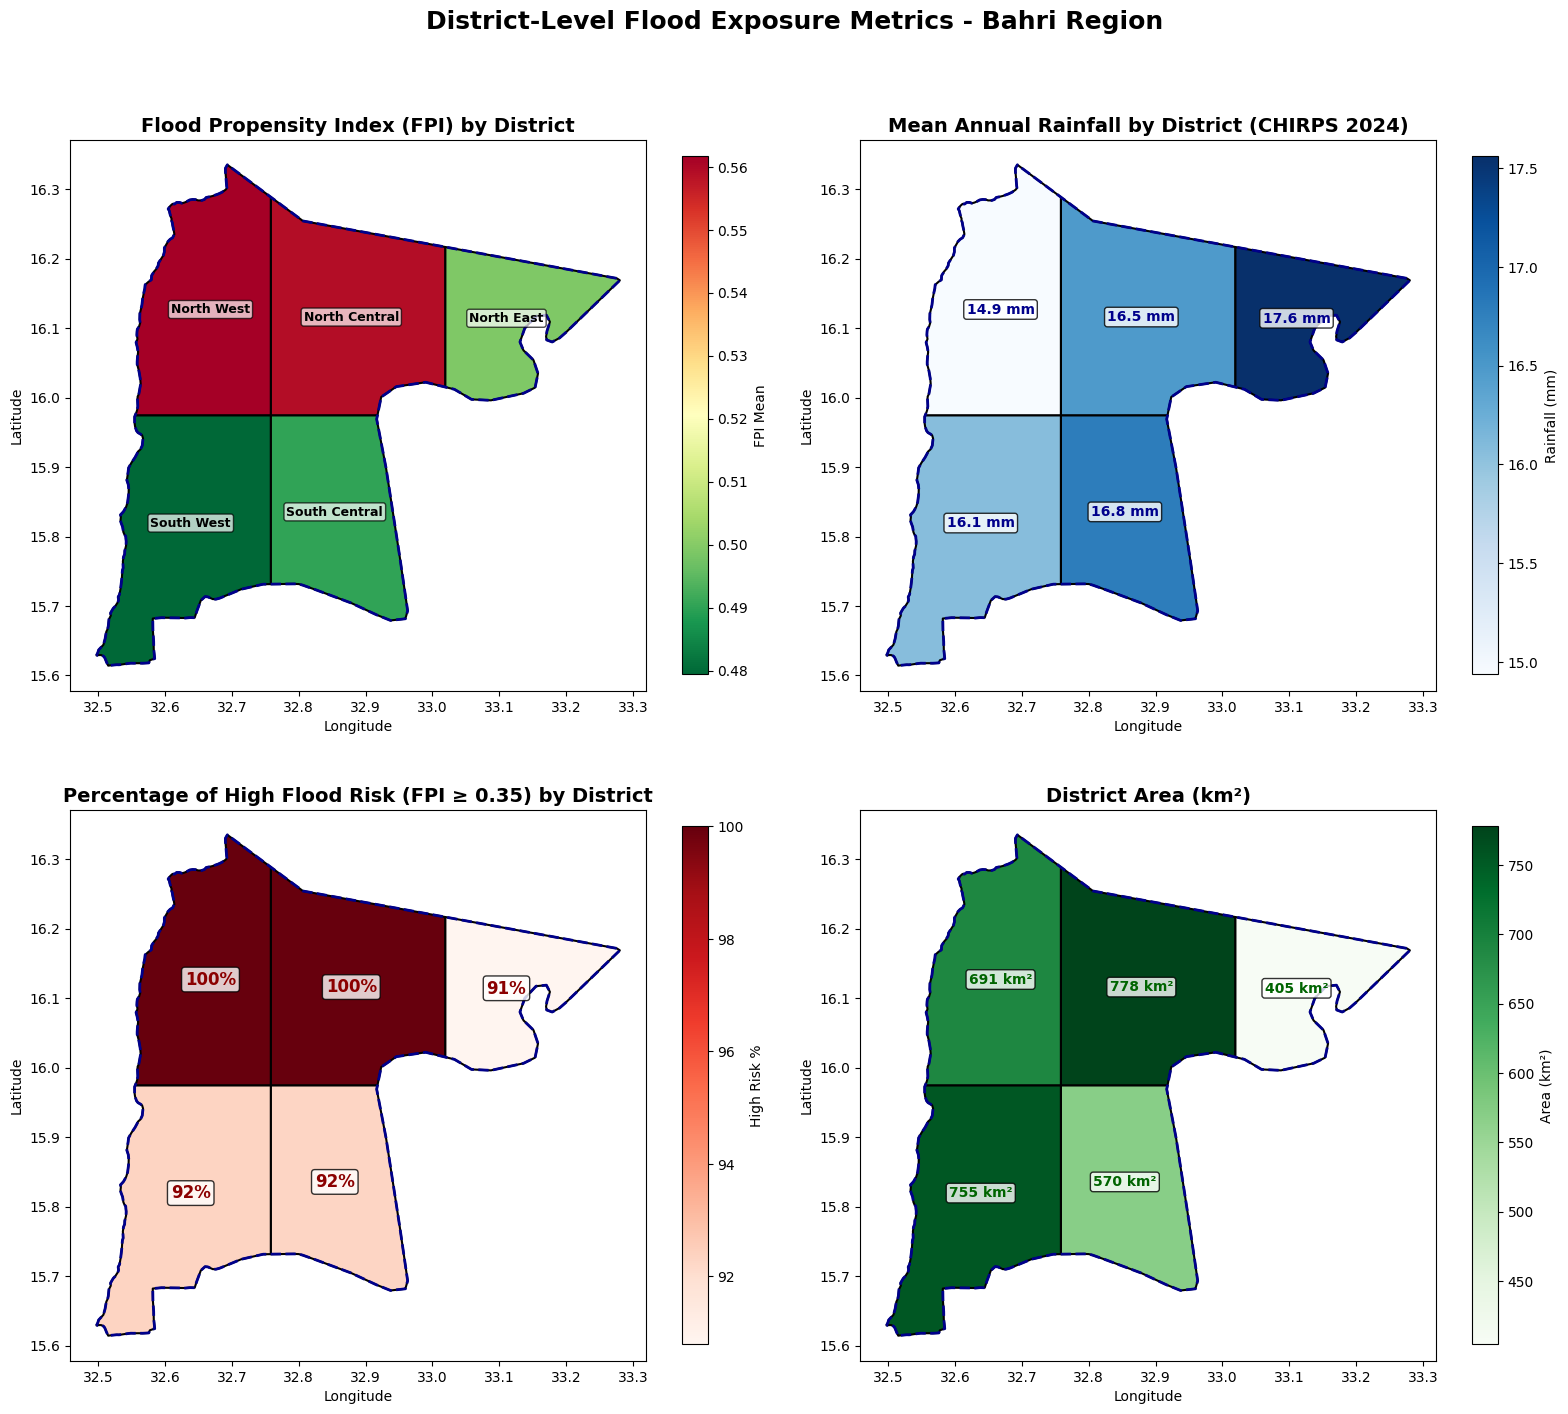

✓ District metrics maps saved to: ../outputs/district_metrics_maps.png


In [3]:
# Create 4-panel choropleth map of district metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Load AOI for boundary overlay
aoi_path = Path("../data/raw/vector/AOI.shp")
aoi = gpd.read_file(aoi_path)

# 1. FPI Mean by District
ax1 = axes[0, 0]
districts_gdf.plot(column='fpi_mean', cmap='RdYlGn_r', legend=True, 
                   edgecolor='black', linewidth=1.5, ax=ax1,
                   legend_kwds={'label': 'FPI Mean', 'shrink': 0.8})
aoi.boundary.plot(ax=ax1, color='darkblue', linewidth=2, linestyle='--')
ax1.set_title('Flood Propensity Index (FPI) by District', fontsize=14, fontweight='bold')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

# Add zone labels
for idx, row in districts_gdf.iterrows():
    centroid = row.geometry.centroid
    ax1.annotate(row['zone_name'].replace(' Bahri', ''), 
                xy=(centroid.x, centroid.y), ha='center', va='center',
                fontsize=9, fontweight='bold', color='black',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7))

# 2. Rainfall Mean by District
ax2 = axes[0, 1]
districts_gdf.plot(column='rainfall_mean_mm', cmap='Blues', legend=True,
                   edgecolor='black', linewidth=1.5, ax=ax2,
                   legend_kwds={'label': 'Rainfall (mm)', 'shrink': 0.8})
aoi.boundary.plot(ax=ax2, color='darkblue', linewidth=2, linestyle='--')
ax2.set_title('Mean Annual Rainfall by District (CHIRPS 2024)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

for idx, row in districts_gdf.iterrows():
    centroid = row.geometry.centroid
    ax2.annotate(f"{row['rainfall_mean_mm']:.1f} mm", 
                xy=(centroid.x, centroid.y), ha='center', va='center',
                fontsize=10, fontweight='bold', color='darkblue',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))

# 3. High Risk Percentage by District
ax3 = axes[1, 0]
districts_gdf.plot(column='pct_high_risk', cmap='Reds', legend=True,
                   edgecolor='black', linewidth=1.5, ax=ax3,
                   legend_kwds={'label': 'High Risk %', 'shrink': 0.8})
aoi.boundary.plot(ax=ax3, color='darkblue', linewidth=2, linestyle='--')
ax3.set_title('Percentage of High Flood Risk (FPI ≥ 0.35) by District', fontsize=14, fontweight='bold')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')

for idx, row in districts_gdf.iterrows():
    centroid = row.geometry.centroid
    ax3.annotate(f"{row['pct_high_risk']:.0f}%", 
                xy=(centroid.x, centroid.y), ha='center', va='center',
                fontsize=12, fontweight='bold', color='darkred',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))

# 4. Area by District
ax4 = axes[1, 1]
districts_gdf.plot(column='area_km2', cmap='Greens', legend=True,
                   edgecolor='black', linewidth=1.5, ax=ax4,
                   legend_kwds={'label': 'Area (km²)', 'shrink': 0.8})
aoi.boundary.plot(ax=ax4, color='darkblue', linewidth=2, linestyle='--')
ax4.set_title('District Area (km²)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Longitude')
ax4.set_ylabel('Latitude')

for idx, row in districts_gdf.iterrows():
    centroid = row.geometry.centroid
    ax4.annotate(f"{row['area_km2']:.0f} km²", 
                xy=(centroid.x, centroid.y), ha='center', va='center',
                fontsize=10, fontweight='bold', color='darkgreen',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))

plt.suptitle('District-Level Flood Exposure Metrics - Bahri Region', 
             fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../outputs/district_metrics_maps.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ District metrics maps saved to: ../outputs/district_metrics_maps.png")